In [2]:
# from __future__ import muli
import itertools
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
plt.style.use("tableau-colorblind10")
import pandas as pd
from scipy import integrate

In [3]:
FS = (8, 4)  # figure size

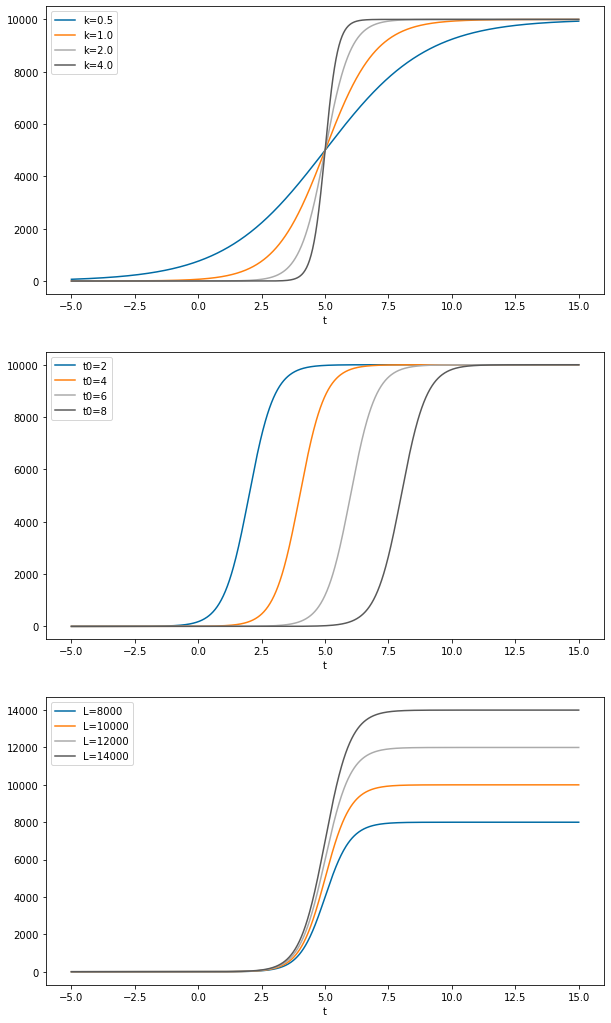

In [4]:
# Giving it some tries
t = np.linspace(-5, 15, 1000)

fig = plt.figure(figsize=(10, 18))

ax = fig.add_subplot(3, 1, 1)
t0, L = 5., 10000.
for k in [0.5,1.,2.,4.]:
    D = L / (1. + np.exp(-k * (t - t0)))
    _ = plt.plot(t, D, label=f'k={k}')
_ = ax.legend()
_ = ax.set_xlabel('t')

ax = fig.add_subplot(3, 1, 2)
L, k = 10000., 2
for t0 in [2,4,6,8]:
    D = L / (1. + np.exp(-k * (t - t0)))
    _ = plt.plot(t, D, label=f't0={t0}')
_ = ax.legend()
_ = ax.set_xlabel('t')

ax = fig.add_subplot(3, 1, 3)
t0, k = 5., 2
for L in range(4, 8):
    L *= 2000
    D = L / (1. + np.exp(-k * (t - t0)))
    _ = plt.plot(t, D, label=f'L={L}')
_ = ax.legend()
_ = ax.set_xlabel('t')

In [5]:
df = pd.read_csv('experimental_results.csv')

In [6]:
df

,Trial,0,637.9,1275.7,1913.5,2551.3,3189.4,3827.2,4465.1,5102.8,...,36999.2,37637.1,38275,38912.9,39550.9,40188.8,40826.6,41464.5,42102.4,42740.3
0,A01,0.0450,0.0449,0.0452,0.0451,0.0459,0.0463,0.0476,0.0485,0.0498,...,0.8127,0.8032,0.8087,0.7994,0.8060,0.7975,0.7849,0.7939,0.7780,0.7924
1,A02,0.0459,0.0459,0.0460,0.0464,0.0468,0.0476,0.0486,0.0496,0.0509,...,0.8858,0.8895,0.9066,0.9023,0.9309,0.9392,0.9300,0.9581,0.9345,0.9616
2,A03,0.0456,0.0458,0.0461,0.0466,0.0471,0.0483,0.0502,0.0508,0.0523,...,0.7782,0.7730,0.7863,0.7877,0.7953,0.7901,0.7775,0.7842,0.7684,0.7794
3,A04,0.0446,0.0448,0.0451,0.0453,0.0457,0.0462,0.0478,0.0483,0.0496,...,0.8160,0.8141,0.8176,0.8104,0.8172,0.8085,0.7979,0.8039,0.7900,0.8030
4,A05,0.0445,0.0449,0.0455,0.0457,0.0459,0.0467,0.0484,0.0491,0.0511,...,0.9163,0.9056,0.9344,0.9267,0.9338,0.9434,0.9260,0.9494,0.9215,0.9427
5,A06,0.0457,0.0459,0.0470,0.0476,0.0464,0.0474,0.0488,0.0496,0.0512,...,0.8082,0.8017,0.8100,0.8059,0.8210,0.8239,0.8162,0.8273,0.8120,0.8228
6,A07,0.0471,0.0481,0.0481,0.0480,0.0482,0.0485,0.0496,0.0501,0.0506,...,0.4180,0.4175,0.4294,0.4291,0.4394,0.4410,0.4398,0.4528,0.4471,0.4623
7,A08,0.0462,0.0474,0.0490,0.0484,0.0495,0.0493,0.0521,0.0529,0.0541,...,0.8316,0.7980,0.8750,0.8514,0.8851,0.8929,0.8690,0.9004,0.8711,0.9012
8,A09,0.0463,0.0464,0.0478,0.0472,0.0478,0.0482,0.0498,0.0505,0.0515,...,0.6156,0.6130,0.6210,0.6258,0.6271,0.6297,0.6172,0.6345,0.6247,0.6464
9,A10,0.0445,0.0451,0.0457,0.0455,0.0457,0.0460,0.0467,0.0473,0.0480,...,0.4182,0.4271,0.4322,0.4338,0.4472,0.4527,0.4484,0.4640,0.4548,0.4717


In [7]:
total = df.groupby('Trial').sum().max(axis=1)

In [8]:
all_sets = total.index.to_list()

In [9]:
all_sets

['A01',
 'A02',
 'A03',
 'A04',
 'A05',
 'A06',
 'A07',
 'A08',
 'A09',
 'A10',
 'A11',
 'A12',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B09',
 'B10',
 'B11',
 'B12',
 'C01',
 'C02',
 'C03',
 'C04',
 'C05',
 'C06',
 'C07',
 'C08',
 'C09',
 'C10',
 'C11',
 'C12']

In [10]:
all_data =  pd.DataFrame()
for set in all_sets:
    temp = df[df['Trial'] == set][df.columns[1:]].T.sum(axis=1)
#     temp.index = pd.to_datetime(temp.index)
    temp = temp.to_frame(set)
    all_data = pd.concat([all_data, temp], axis=1)
all_data['$argA^fbr$ <antibio>'] = all_data[['A01', 'B01','C01','A07', 'B07','C07']].mean(axis=1)
all_data['$cysE-mut$ <antibio>'] = all_data[['A02', 'B02','C02','A08', 'B08','C08']].mean(axis=1)
all_data['$myrcene$ <antibio>'] = all_data[['A03', 'B03','C03','A09', 'B09','C09']].mean(axis=1)
all_data['$argA^fbr$'] = all_data[['A04', 'B04','C04','A10', 'B10','C10']].mean(axis=1)
all_data['$cysE-mut$'] = all_data[['A05', 'B05','C05','A11', 'B11','C11']].mean(axis=1)
all_data['$myrcene$'] = all_data[['A06', 'B06','C06','A12', 'B12','C12']].mean(axis=1)
# all_data['avg11_antibio'] = all_data[['A07', 'B07','C07']].mean(axis=1)
# all_data['avg22_antibio'] = all_data[['A08', 'B08','C08']].mean(axis=1)
# all_data['avg33_antibio'] = all_data[[].mean(axis=1)
# all_data['avg44_antibio'] = all_data[[].mean(axis=1)
# all_data['avg55_antibio'] = all_data[[].mean(axis=1)
# all_data['avg66_antibio'] = all_data[[]].mean(axis=1)

In [11]:
all_data

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,C09,C10,C11,C12,$argA^fbr$ <antibio>,$cysE-mut$ <antibio>,$myrcene$ <antibio>,$argA^fbr$,$cysE-mut$,$myrcene$
0,0.0450,0.0459,0.0456,0.0446,0.0445,0.0457,0.0471,0.0462,0.0463,0.0445,...,0.0515,0.0468,0.0470,0.0460,0.073117,0.047783,0.047433,0.047117,0.046033,0.046967
637.9,0.0449,0.0459,0.0458,0.0448,0.0449,0.0459,0.0481,0.0474,0.0464,0.0451,...,0.0517,0.0472,0.0473,0.0463,0.077183,0.048050,0.047417,0.047317,0.046433,0.047383
1275.7,0.0452,0.0460,0.0461,0.0451,0.0455,0.0470,0.0481,0.0490,0.0478,0.0457,...,0.0503,0.0473,0.0466,0.0461,0.078783,0.048250,0.048017,0.047367,0.046683,0.047700
1913.5,0.0451,0.0464,0.0466,0.0453,0.0457,0.0476,0.0480,0.0484,0.0472,0.0455,...,0.0539,0.0480,0.0476,0.0467,0.049050,0.048700,0.048550,0.047833,0.047167,0.048033
2551.3,0.0459,0.0468,0.0471,0.0457,0.0459,0.0464,0.0482,0.0495,0.0478,0.0457,...,0.0522,0.0474,0.0470,0.0464,0.049150,0.049017,0.048767,0.047767,0.047050,0.047983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40188.8,0.7975,0.9392,0.7901,0.8085,0.9434,0.8239,0.4410,0.8929,0.6297,0.4527,...,0.6560,0.7294,0.8325,0.7448,0.635283,0.928117,0.718817,0.785667,0.876267,0.779350
40826.6,0.7849,0.9300,0.7775,0.7979,0.9260,0.8162,0.4398,0.8690,0.6172,0.4484,...,0.6598,0.7273,0.8038,0.7334,0.632733,0.912383,0.710133,0.773083,0.853150,0.768233
41464.5,0.7939,0.9581,0.7842,0.8039,0.9494,0.8273,0.4528,0.9004,0.6345,0.4640,...,0.6582,0.7427,0.8421,0.7608,0.639683,0.932050,0.717383,0.804550,0.883783,0.783950
42102.4,0.7780,0.9345,0.7684,0.7900,0.9215,0.8120,0.4471,0.8711,0.6247,0.4548,...,0.6595,0.7418,0.8173,0.7418,0.630433,0.918200,0.707533,0.786550,0.869767,0.769083


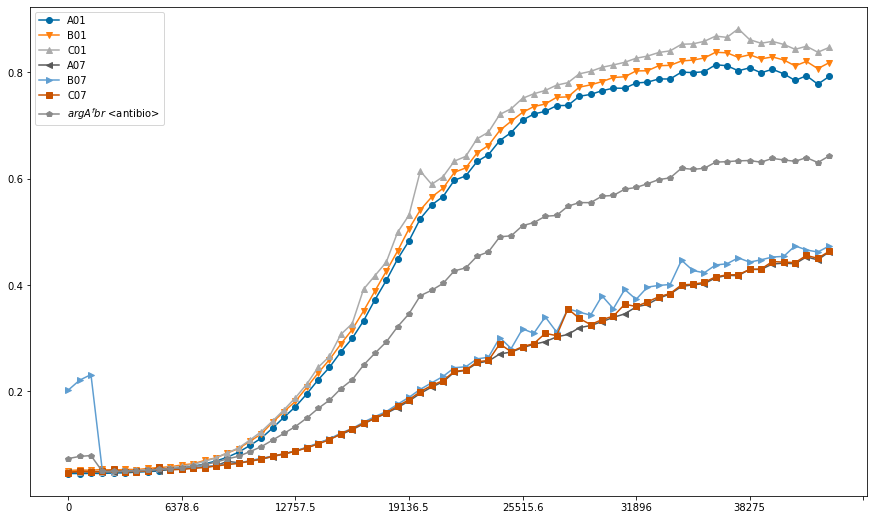

In [12]:
start = 0
ax = all_data[['A01', 'B01','C01','A07','B07','C07','$argA^fbr$ <antibio>']][start:].plot(style='-', figsize=(15,9))
markers = itertools.cycle(("o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "X", "D", '.'))
for i, line in enumerate(ax.get_lines()):
    marker = next(markers)
    line.set_marker(marker)
_ = ax.legend()

In [13]:
# Define funcion with the coefficients to estimate
def logistic(t, a, k, N_m, offset):
    return N_m / (1 + a * np.exp(-k*t)) + offset

In [14]:
# Randomly initialize the coefficients
p0 = np.random.random(size=4)
p0

array([0.48861782, 0.46148228, 0.26359138, 0.61784546])

In [15]:
bounds = (0., [10017.,3.,10019834.,10000.])

In [16]:
import scipy.optimize as optim
x = np.array([float(x) for x in all_data.index])
y = np.array([float(x) for x in all_data['$argA^fbr$ <antibio>']])

In [17]:
(a,k,N_m,offset),cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)

In [18]:
a,k,N_m,offset

(81.26769623175933,
 0.0002283117473830338,
 0.59638969424261,
 0.03403317076050072)

In [19]:
def test_logistic(t):
    return N_m / (1 + a * np.exp(-k*t)) + offset

Text(0, 0.5, 'Concentration')

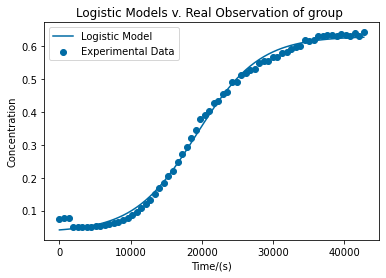

In [20]:
plt.scatter(x, y)
plt.plot(x, test_logistic(x))
plt.title('Logistic Models v. Real Observation of group $argA^fbr$ <antibio>')
plt.title('Logistic Models v. Real Observation of group ')
plt.legend(['Logistic Model','Experimental Data'])
plt.xlabel('Time/(s)')
plt.ylabel('Concentration')

In [21]:
ret_data = {
    'group_name':[],
    'a':[],
    'k':[],
    'N_m':[],
    'offset':[],
    }

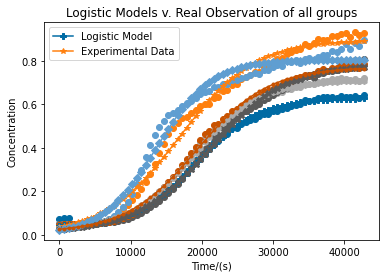

In [22]:
for group in all_data.columns[all_data.columns.get_loc('$argA^fbr$ <antibio>'):]:
    # cnt += 1
    p0 = np.random.random(size=4)
    y = np.array([float(x) for x in all_data[group]])
    (a,k,N_m,offset),cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
    test_logistic = lambda t : N_m / (1 + a * np.exp(-k*t)) + offset
    plt.scatter(x, y)
    ret_data['group_name'].append(group)
    ret_data['a'].append(a)
    ret_data['k'].append(k)
    ret_data['N_m'].append(N_m)
    ret_data['offset'].append(offset)
    plt.plot(x, test_logistic(x),marker = next(markers))
    plt.title(f'Logistic Models v. Real Observation of all groups')
    plt.legend(['Logistic Model','Experimental Data'])
    plt.xlabel('Time/(s)')
    plt.ylabel('Concentration')

In [23]:
output_df = pd.DataFrame(ret_data)
output_df

,group_name,a,k,N_m,offset
0,$argA^fbr$ <antibio>,81.267850,0.000228,0.596390,3.403320e-02
1,$cysE-mut$ <antibio>,24.231425,0.000189,0.897522,5.341923e-26
2,$myrcene$ <antibio>,60.918954,0.000218,0.693091,2.001468e-02
3,$argA^fbr$,56.760416,0.000191,0.771270,1.323633e-02
4,$cysE-mut$,35.514991,0.000261,0.805412,3.126210e-29
5,$myrcene$,48.169664,0.000201,0.761660,9.799065e-03


In [24]:
output_df.to_csv('./outputs/out.csv')

In [25]:
k1, k2, k3,k4, k5, k6 = ret_data['k']

Text(0.5, 1.0, 'Plotting the changes of growth rates of $argA^{fbr}$,\n$cysE-mut$, $myrcene$ as time passes')

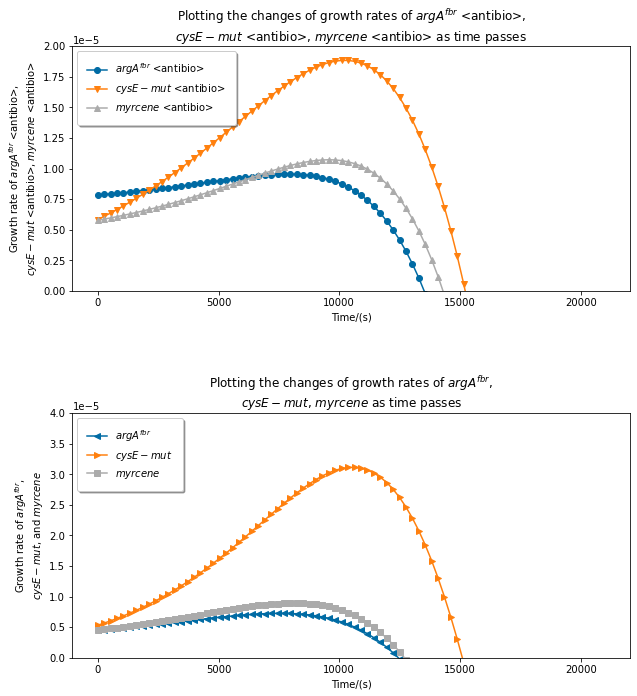

In [26]:
t = np.linspace(0,21000,80)
zero = np.linspace(0,0,1000)
quick_logistic = lambda t,i,scale=1:scale*logistic(t, ret_data['a'][i],ret_data['k'][i], ret_data['N_m'][i], ret_data['offset'][i])

derivative = lambda t,i,ii,iii,k1,k2,k3: k1 * quick_logistic(t,i) * (1- quick_logistic(t,i)/ret_data['N_m'][i]-(k2/k1)*(quick_logistic(t,ii)/ret_data['N_m'][i])-(k3/k1)*(quick_logistic(t,iii)/ret_data['N_m'][i]))

# dA_test = 
fig = plt.figure(figsize=(10, 18))
plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(3,1,1)
# ax.set_ylim(bottom=0.4, top=19)
ax1.set_ylim(0,0.00002)
# for i in t[1:]:
#     val = derivative(i,0,1,2,k1,k2,k3)
#     if derivative(0,0,1,2,k1,k2,k3) >= val:
#         rect = patches.Rectangle((0,0),i,val,linewidth=1,edgecolor='r',facecolor='none')
#         ax1.text(i, val, '({},\n {})'.format(i, val))
#         break
ax1.plot(t, derivative(t,0,1,2,k1,k2,k3),marker = next(markers),label='$argA^{fbr}$ <antibio>')
ax1.plot(t, derivative(t,1,0,2,k2,k1,k3),marker = next(markers),label='$cysE-mut$ <antibio>')
ax1.plot(t, derivative(t,2,0,1,k3,k1,k2),marker = next(markers),label='$myrcene$ <antibio>')
# bound = min(derivative(0,0,1,2,k1,k2,k3),derivative(0,1,0,2,k2,k1,k3),derivative(0,2,0,1,k3,k1,k2))
leg = ax1.legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1);
# ax1.add_patch(rect)
ax1.set_xlabel('Time/(s)')
ax1.set_ylabel("Growth rate of $argA^{fbr}$ <antibio>,\n$cysE-mut$ <antibio>, $myrcene$ <antibio>")
ax1.set_title("Plotting the changes of growth rates of $argA^{fbr}$ <antibio>,\n$cysE-mut$ <antibio>, $myrcene$ <antibio> as time passes")

ax2 = fig.add_subplot(3,1,2)
# ax.set_ylim(bottom=0.4, top=19)
ax2.set_ylim(0,0.00004)
# for i in t[1:]:
#     val = derivative(i,3,4,5,k4,k5,k6)
#     if derivative(0,3,4,5,k4,k5,k6) >= val:
#         rect = patches.Rectangle((0,0),i,val,linewidth=1,edgecolor='r',facecolor='none')
#         ax2.text(i, val, '({},\n {})'.format(i, val))
#         break
ax2.plot(t, derivative(t,3,4,5,k4,k5,k6),marker = next(markers),label='$argA^{fbr}$')
ax2.plot(t, derivative(t,4,3,5,k5,k4,k6),marker = next(markers),label='$cysE-mut$')
ax2.plot(t, derivative(t,5,3,4,k6,k4,k5),marker = next(markers),label='$myrcene$')
leg = ax2.legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1);
# ax2.add_patch(rect)
ax2.set_xlabel('Time/(s)')
ax2.set_ylabel("Growth rate of $argA^{fbr}$,\n$cysE-mut$, and $myrcene$")
ax2.set_title("Plotting the changes of growth rates of $argA^{fbr}$,\n$cysE-mut$, $myrcene$ as time passes")

Text(0.5, 1.0, 'Plotting the changes of concentration of $argA^{fbr}$,\n$cysE-mut$, $myrcene$ as time passes')

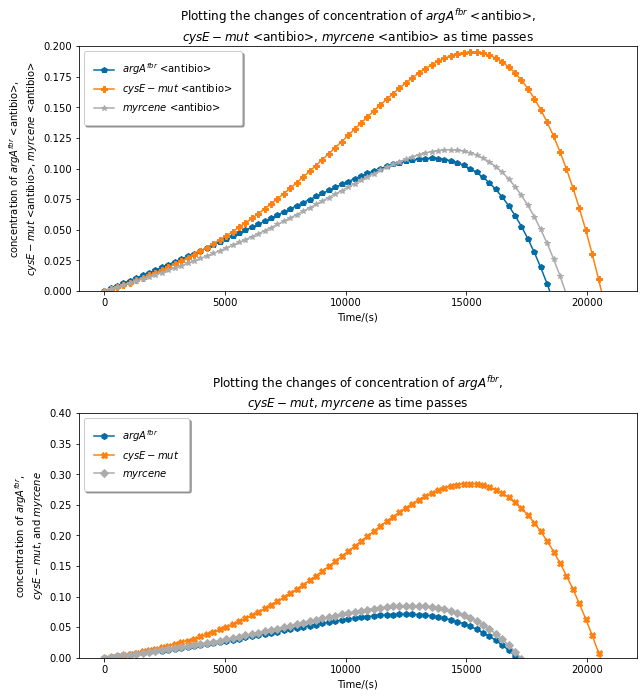

In [27]:
tt = np.linspace(0,21000,80)

quick_logistic = lambda t,i,scale=1: scale * logistic(t, ret_data['a'][i],ret_data['k'][i], ret_data['N_m'][i], ret_data['offset'][i])

derivative = lambda t,i,ii,iii,k1,k2,k3: k1 * quick_logistic(t,i) * (1- quick_logistic(t,i)/ret_data['N_m'][i]-(k2/k1)*(quick_logistic(t,ii)/ret_data['N_m'][i])-(k3/k1)*(quick_logistic(t,iii)/ret_data['N_m'][i]))

def Integral(x,i,ii,iii,k1,k2,k3):
    f = lambda x: derivative(x,i,ii,iii,k1,k2,k3)
    res = np.zeros_like(x)
    for j,val in enumerate(x):
        y,err = integrate.quad(f,0,val)
        res[j] = y
    return res
# dA_test = 
fig = plt.figure(figsize=(10, 18))
plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(3,1,1)
# ax.set_ylim(bottom=0.4, top=19)
ax1.set_ylim(0,0.2)
# for i in t[1:]:
#     val = derivative(i,0,1,2,k1,k2,k3)
#     if derivative(0,0,1,2,k1,k2,k3) >= val:
#         rect = patches.Rectangle((0,0),i,val,linewidth=1,edgecolor='r',facecolor='none')
#         ax1.text(i, val, '({},\n {})'.format(i, val))
#         break
ax1.plot(tt, Integral(tt,0,1,2,k1,k2,k3),marker = next(markers),label='$argA^{fbr}$ <antibio>')
ax1.plot(tt, Integral(tt,1,0,2,k2,k1,k3),marker = next(markers),label='$cysE-mut$ <antibio>')
ax1.plot(tt, Integral(tt,2,0,1,k3,k1,k2),marker = next(markers),label='$myrcene$ <antibio>')
# bound = min(derivative(0,0,1,2,k1,k2,k3),derivative(0,1,0,2,k2,k1,k3),derivative(0,2,0,1,k3,k1,k2))
leg = ax1.legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1);
# ax1.add_patch(rect)
ax1.set_xlabel('Time/(s)')
ax1.set_ylabel("concentration of $argA^{fbr}$ <antibio>,\n$cysE-mut$ <antibio>, $myrcene$ <antibio>")
ax1.set_title("Plotting the changes of concentration of $argA^{fbr}$ <antibio>,\n$cysE-mut$ <antibio>, $myrcene$ <antibio> as time passes")

ax2 = fig.add_subplot(3,1,2)
# ax.set_ylim(bottom=0.4, top=19)
ax2.set_ylim(0,0.4)
# for i in t[1:]:
#     val = derivative(i,3,4,5,k4,k5,k6)
#     if derivative(0,3,4,5,k4,k5,k6) >= val:
#         rect = patches.Rectangle((0,0),i,val,linewidth=1,edgecolor='r',facecolor='none')
#         ax2.text(i, val, '({},\n {})'.format(i, val))
#         break
ax2.plot(tt, Integral(tt,3,4,5,k4,k5,k6),marker = next(markers),label='$argA^{fbr}$')
ax2.plot(tt, Integral(tt,4,3,5,k5,k4,k6),marker = next(markers),label='$cysE-mut$')
ax2.plot(tt, Integral(tt,5,3,4,k6,k4,k5),marker = next(markers),label='$myrcene$')
leg = ax2.legend(loc='upper left',fancybox=True, framealpha=1, shadow=True, borderpad=1);
# ax2.add_patch(rect)
ax2.set_xlabel('Time/(s)')
ax2.set_ylabel("concentration of $argA^{fbr}$,\n$cysE-mut$, and $myrcene$")
ax2.set_title("Plotting the changes of concentration of $argA^{fbr}$,\n$cysE-mut$, $myrcene$ as time passes")

In [28]:
all_val = list(zip(Integral(tt,0,1,2,k1,k2,k3),Integral(tt,1,0,2,k2,k1,k3),Integral(tt,2,0,1,k3,k1,k2)))
for i in range(1,len(all_val)):
    if min(all_val[i]) <= 0:
        print(tt[i])
        break

18607.594936708858


In [29]:
all_val = list(zip(Integral(tt,3,4,5,k4,k5,k6),Integral(tt,4,3,5,k5,k4,k6),Integral(tt,5,3,4,k6,k4,k5)))
for i in range(1,len(all_val)):
    if min(all_val[i]) <= 0:
        print(tt[i])
        break

17278.481012658227


---
# BELOW ARE DRAFTS

In [30]:
from scipy.optimize import minimize

In [45]:
scaled_derivative = lambda t,k1,k2,k3,x,y,z: k1 * A * (1- quick_logistic(t,i,x)/ret_data['N_m'][i]-(k2/k1)*(quick_logistic(t,ii,y)/ret_data['N_m'][i])-(k3/k1)*(quick_logistic(t,iii,z)/ret_data['N_m'][i]))

def Integral_with_scaling(xx,i,ii,iii,k1,k2,k3,x,y,z):
    f = lambda xx: scaled_derivative(xx,i,ii,iii,k1,k2,k3,x,y,z)
    res = np.zeros_like(xx)
    for j,val in enumerate(xx):
        y,err = integrate.quad(f,0,val)
        res[j] = y
    return res

def objective(params):
    x,y = params
    all_val = list(zip(Integral_with_scaling(tt,3,4,5,k4,k5,k6,1,x,y),Integral_with_scaling(tt,4,3,5,k5,k4,k6,x,1,y),Integral_with_scaling(tt,5,3,4,k6,k4,k5,y,1,x)))
    for i in range(1,len(all_val)):
        if min(all_val[i]) <= 0:
            return tt[i]
            break

In [47]:
k = objective([1.,1])
k

19670.886075949365

In [36]:
p0 = np.random.random(size=2)
p0

array([0.36257077, 0.45763558])

In [52]:
minimize(lambda arr: -objective(arr),p0)

TypeError: bad operand type for unary -: 'NoneType'

In [110]:
objective(p0)

In [639]:
params = [1,1]
updated_time = 0
temp_func = lambda x,y,updated_time: min(derivative_with_scaling_1(updated_time,x,y),derivative_with_scaling_2(updated_time,x,y),derivative_with_scaling_3(updated_time,x,y))
for i in range(10):
    for j in t[1:]:
        x,y = params
        val = min(derivative_with_scaling_1(i,x,y),derivative_with_scaling_2(i,x,y),derivative_with_scaling_3(i,x,y))
        if val<=0:
            updated_time = j
            break
    # assert False
    # assert False
    # assert False 
    # assert False
    params = minimize(lambda arr,updated_time:-temp_func(updated_time,arr[0],arr[1]),x0=params,args=updated_time).x
    x,y = params
    print(f"iter {i}, {objective(params)},value {temp_func(updated_time,x,y)}")
    # assert False

iter 0, 13569.620253164558,value 0.0
iter 1, 13569.620253164558,value 0.0
iter 2, 13569.620253164558,value 0.0
iter 3, 13569.620253164558,value 0.0
iter 4, 13569.620253164558,value 0.0
iter 5, 13569.620253164558,value 0.0
iter 6, 13569.620253164558,value 0.0
iter 7, 13569.620253164558,value 0.0
iter 8, 13569.620253164558,value 0.0
iter 9, 13569.620253164558,value 0.0


In [635]:
params

array([1., 1.])

In [518]:
i = objective(res.x)

In [525]:
i = 13569.620253164558

In [536]:
def fnc(params):
    x,y = params
    return min(derivative_with_scaling_1(i,x,y),derivative_with_scaling_2(i,x,y),derivative_with_scaling_3(i,x,y))

In [537]:
p0 = np.random.random(size=2)
p0

array([0.26309931, 0.04349631])

In [538]:
fnc(p0)

6.770824185470468e-07

In [539]:
ret = minimize(lambda x:-fnc(x),p0)

In [540]:
ret.x

array([0.2501313 , 0.33309734])

In [541]:
fnc(ret.x)

5.254417101674001e-06

In [633]:
minimize(lambda :, -1)

      fun: 1.0000000000000035e-08
 hess_inv: array([[1]])
      jac: array([4.00000894e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.01])